# Plankton Image Classification with Transfer Learning

This notebook trains multiple pretrained models (VGG16, ResNet50V2, InceptionV3, Xception, MobileNetV2) on plankton images (20 classes), 30 images for each classes
and evaluates them with accuracy, precision, recall, F1, AUC, confusion matrices, ROC curves, etc.
All results (plots, metrics, reports, trained models) are saved in `research_outputs/`.


In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import os, time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import shutil

## Dataset Setup

In [2]:
DATASET_PATH = "Dataset_9"
OUTPUT_PATH = "Output_9"
os.makedirs(OUTPUT_PATH, exist_ok=True)

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 20
EPOCHS = 25

In [3]:
def create_train_val_test_split(dataset_path, output_base="Dataset_Split_9", train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-5, "Ratios must sum to 1"
    
    splits = {'train': train_ratio, 'val': val_ratio, 'test': test_ratio}
    
    # Create split directories
    for split in splits.keys():
        os.makedirs(os.path.join(output_base, split), exist_ok=True)
    
    # Get all classes
    classes = [d for d in os.listdir(dataset_path) 
               if os.path.isdir(os.path.join(dataset_path, d))]
    
    print(f"Found {len(classes)} classes: {classes}")
    
    for cls in classes:
        cls_path = os.path.join(dataset_path, cls)
        images = [f for f in os.listdir(cls_path) 
                  if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Split images
        train_imgs, temp_imgs = train_test_split(images, test_size=(val_ratio + test_ratio), 
                                                   random_state=42)
        val_imgs, test_imgs = train_test_split(temp_imgs, 
                                                test_size=test_ratio/(val_ratio + test_ratio),
                                                random_state=42)
        
        # Copy files to respective directories
        for split_name, split_imgs in [('train', train_imgs), ('val', val_imgs), ('test', test_imgs)]:
            split_cls_path = os.path.join(output_base, split_name, cls)
            os.makedirs(split_cls_path, exist_ok=True)
            
            for img in split_imgs:
                src = os.path.join(cls_path, img)
                dst = os.path.join(split_cls_path, img)
                if not os.path.exists(dst):
                    shutil.copy2(src, dst)
        
        print(f"Class '{cls}': Train={len(train_imgs)}, Val={len(val_imgs)}, Test={len(test_imgs)}")
    
    return output_base

# Create split only if not exists
SPLIT_PATH = "Dataset_Split_9"
SPLIT_PATH = create_train_val_test_split(DATASET_PATH)

Found 20 classes: ['Asterionellopsis', 'Cerataulina', 'Ceratium', 'Chaetoceros', 'Chrysochromulina', 'Ciliate_mix', 'Coscinodiscus', 'Cylindrotheca', 'Dactyliosolen', 'Dictyocha', 'Dinobryon', 'Dytilum', 'Eucampia', 'Euglena', 'Guinardia_delicatula', 'Guinardia_flaccida', 'Guinardia_striata', 'Gyrodinium', 'Leptocylindrus', 'Rhizosolenia']
Class 'Asterionellopsis': Train=21, Val=4, Test=5
Class 'Cerataulina': Train=21, Val=4, Test=5
Class 'Ceratium': Train=21, Val=4, Test=5
Class 'Chaetoceros': Train=21, Val=4, Test=5
Class 'Chrysochromulina': Train=21, Val=4, Test=5
Class 'Ciliate_mix': Train=21, Val=4, Test=5
Class 'Coscinodiscus': Train=21, Val=4, Test=5
Class 'Cylindrotheca': Train=21, Val=4, Test=5
Class 'Dactyliosolen': Train=21, Val=4, Test=5
Class 'Dictyocha': Train=21, Val=4, Test=5
Class 'Dinobryon': Train=21, Val=4, Test=5
Class 'Dytilum': Train=21, Val=4, Test=5
Class 'Eucampia': Train=21, Val=4, Test=5
Class 'Euglena': Train=21, Val=4, Test=5
Class 'Guinardia_delicatula': 

## Data Generators

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Validation - only rescaling
val_datagen = ImageDataGenerator(rescale=1./255)

# Test - only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    os.path.join(SPLIT_PATH, 'train'), target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    os.path.join(SPLIT_PATH, 'val'), target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(SPLIT_PATH, 'test'), target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

class_labels = list(test_generator.class_indices.keys())

print(f"\nClasses: {class_labels}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

Found 420 images belonging to 20 classes.
Found 80 images belonging to 20 classes.
Found 100 images belonging to 20 classes.

Classes: ['Asterionellopsis', 'Cerataulina', 'Ceratium', 'Chaetoceros', 'Chrysochromulina', 'Ciliate_mix', 'Coscinodiscus', 'Cylindrotheca', 'Dactyliosolen', 'Dictyocha', 'Dinobryon', 'Dytilum', 'Eucampia', 'Euglena', 'Guinardia_delicatula', 'Guinardia_flaccida', 'Guinardia_striata', 'Gyrodinium', 'Leptocylindrus', 'Rhizosolenia']
Training samples: 420
Validation samples: 80
Test samples: 100


## Pretrained Models Setup

In [ ]:
MODELS = {
    "VGG16": tf.keras.applications.VGG16,
    "ResNet50V2": tf.keras.applications.ResNet50V2,
    "InceptionV3": tf.keras.applications.InceptionV3,
    "Xception": tf.keras.applications.Xception,
    "MobileNetV2": tf.keras.applications.MobileNetV2,
}

def build_model(base_model_class, input_shape, num_classes):
    base_model = base_model_class(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

compiled_models = {name: build_model(base, IMAGE_SIZE + (3,), NUM_CLASSES)
                   for name, base in MODELS.items()}

## Training with Checkpoints and Logging

In [6]:
history = {}
for name, model in compiled_models.items():
    print(f"\nTraining {name}...")
    model_dir = os.path.join(OUTPUT_PATH, name)
    os.makedirs(model_dir, exist_ok=True)
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, f"{name}_best.h5"),
        monitor='val_accuracy', save_best_only=True, mode='max'
    )
    csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(model_dir, f"{name}_training_log.csv"))
    earlystop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    
    start = time.time()
    hist = model.fit(
        train_generator, epochs=EPOCHS, validation_data=validation_generator,
        callbacks=[checkpoint, csv_logger, earlystop]
    )
    end = time.time()
    
    history[name] = (hist, end - start)
    model.save(os.path.join(model_dir, f"{name}_final.h5"))
    print(f" Model {name} trained in {end-start:.2f} seconds and saved.")


Training VGG16...


e:\miniconda\envs\ml_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.0598 - loss: 3.1833 - precision: 0.0000e+00 - recall: 0.0000e+00 

14/14 ━━━━━━━━━━━━━━━━━━━━ 356s 25s/step - accuracy: 0.0714 - loss: 3.1156 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2125 - val_loss: 2.8417 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 355s 26s/step - accuracy: 0.1381 - loss: 2.8858 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2125 - val_loss: 2.7210 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.1297 - loss: 2.7959 - precision: 0.0000e+00 - recall: 0.0000e+00 

14/14 ━━━━━━━━━━━━━━━━━━━━ 384s 29s/step - accuracy: 0.1548 - loss: 2.7609 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3625 - val_loss: 2.5841 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.2584 - loss: 2.6273 - precision: 0.0000e+00 - recall: 0.0000e+00 

14/14 ━━━━━━━━━━━━━━━━━━━━ 411s 26s/step - accuracy: 0.2643 - loss: 2.6178 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4125 - val_loss: 2.4510 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.2547 - loss: 2.5875 - precision: 0.5714 - recall: 0.0024 

14/14 ━━━━━━━━━━━━━━━━━━━━ 360s 26s/step - accuracy: 0.3000 - loss: 2.5062 - precision: 1.0000 - recall: 0.0048 - val_accuracy: 0.5375 - val_loss: 2.3105 - val_precision: 1.0000 - val_recall: 0.0250
Epoch 6/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 359s 26s/step - accuracy: 0.3524 - loss: 2.3727 - precision: 1.0000 - recall: 0.0167 - val_accuracy: 0.5125 - val_loss: 2.1838 - val_precision: 1.0000 - val_recall: 0.0375
Epoch 7/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 359s 26s/step - accuracy: 0.3786 - loss: 2.2537 - precision: 1.0000 - recall: 0.0238 - val_accuracy: 0.4625 - val_loss: 2.0962 - val_precision: 1.0000 - val_recall: 0.0375
Epoch 8/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.3476 - loss: 2.1934 - precision: 1.0000 - recall: 0.0220 

14/14 ━━━━━━━━━━━━━━━━━━━━ 360s 26s/step - accuracy: 0.3786 - loss: 2.1874 - precision: 1.0000 - recall: 0.0238 - val_accuracy: 0.6125 - val_loss: 1.9824 - val_precision: 1.0000 - val_recall: 0.0750
Epoch 9/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 371s 27s/step - accuracy: 0.4524 - loss: 2.0624 - precision: 0.9130 - recall: 0.0500 - val_accuracy: 0.6125 - val_loss: 1.8913 - val_precision: 1.0000 - val_recall: 0.0750
Epoch 10/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.5238 - loss: 1.8649 - precision: 1.0000 - recall: 0.0907 

14/14 ━━━━━━━━━━━━━━━━━━━━ 382s 27s/step - accuracy: 0.4786 - loss: 1.9563 - precision: 1.0000 - recall: 0.0810 - val_accuracy: 0.6875 - val_loss: 1.7981 - val_precision: 1.0000 - val_recall: 0.1000
Epoch 11/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 362s 26s/step - accuracy: 0.4548 - loss: 1.9412 - precision: 0.9091 - recall: 0.0714 - val_accuracy: 0.6750 - val_loss: 1.7273 - val_precision: 1.0000 - val_recall: 0.1250
Epoch 12/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 358s 26s/step - accuracy: 0.5095 - loss: 1.8270 - precision: 0.9762 - recall: 0.0976 - val_accuracy: 0.6250 - val_loss: 1.6677 - val_precision: 1.0000 - val_recall: 0.1375
Epoch 13/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 357s 26s/step - accuracy: 0.5119 - loss: 1.7915 - precision: 0.9388 - recall: 0.1095 - val_accuracy: 0.6250 - val_loss: 1.6080 - val_precision: 1.0000 - val_recall: 0.1500
Epoch 14/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 357s 26s/step - accuracy: 0.5238 - loss: 1.7084 - precision: 0.9333 - recall: 0.1667 - val_accuracy: 0.6625 - val_loss: 1.5501 - 

14/14 ━━━━━━━━━━━━━━━━━━━━ 358s 26s/step - accuracy: 0.5548 - loss: 1.5944 - precision: 0.9012 - recall: 0.1738 - val_accuracy: 0.7375 - val_loss: 1.3916 - val_precision: 1.0000 - val_recall: 0.2500
Epoch 18/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 358s 26s/step - accuracy: 0.5881 - loss: 1.5146 - precision: 0.9759 - recall: 0.1929 - val_accuracy: 0.6625 - val_loss: 1.3652 - val_precision: 1.0000 - val_recall: 0.2625
Epoch 19/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 377s 27s/step - accuracy: 0.5476 - loss: 1.4870 - precision: 0.8919 - recall: 0.2357 - val_accuracy: 0.7375 - val_loss: 1.3040 - val_precision: 1.0000 - val_recall: 0.3000
Epoch 20/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 358s 26s/step - accuracy: 0.5667 - loss: 1.4713 - precision: 0.8729 - recall: 0.2452 - val_accuracy: 0.7000 - val_loss: 1.2926 - val_precision: 1.0000 - val_recall: 0.2875
Epoch 21/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.6105 - loss: 1.3451 - precision: 0.9459 - recall: 0.2935 

14/14 ━━━━━━━━━━━━━━━━━━━━ 359s 26s/step - accuracy: 0.5929 - loss: 1.3816 - precision: 0.9328 - recall: 0.2643 - val_accuracy: 0.7750 - val_loss: 1.2505 - val_precision: 1.0000 - val_recall: 0.3125
Epoch 22/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 389s 28s/step - accuracy: 0.5905 - loss: 1.3690 - precision: 0.9274 - recall: 0.2738 - val_accuracy: 0.6625 - val_loss: 1.2449 - val_precision: 1.0000 - val_recall: 0.3625
Epoch 23/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 358s 26s/step - accuracy: 0.6048 - loss: 1.3752 - precision: 0.9286 - recall: 0.2786 - val_accuracy: 0.6750 - val_loss: 1.2226 - val_precision: 1.0000 - val_recall: 0.3500
Epoch 24/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 359s 26s/step - accuracy: 0.5857 - loss: 1.3055 - precision: 0.9200 - recall: 0.2738 - val_accuracy: 0.7250 - val_loss: 1.1825 - val_precision: 1.0000 - val_recall: 0.3500
Epoch 25/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 360s 26s/step - accuracy: 0.5881 - loss: 1.3451 - precision: 0.9104 - recall: 0.2905 - val_accuracy: 0.7500 - val_loss: 1.1542 - 

 Model VGG16 trained in 9126.85 seconds and saved.

Training ResNet50V2...
Epoch 1/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1585 - loss: 3.2279 - precision_1: 0.3480 - recall_1: 0.0416

14/14 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.2619 - loss: 2.7498 - precision_1: 0.6667 - recall_1: 0.0952 - val_accuracy: 0.5875 - val_loss: 1.6503 - val_precision_1: 0.8696 - val_recall_1: 0.2500
Epoch 2/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5318 - loss: 1.6434 - precision_1: 0.8499 - recall_1: 0.2683

14/14 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.5405 - loss: 1.5573 - precision_1: 0.8224 - recall_1: 0.2976 - val_accuracy: 0.7500 - val_loss: 1.0764 - val_precision_1: 0.8974 - val_recall_1: 0.4375
Epoch 3/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6824 - loss: 1.1673 - precision_1: 0.8791 - recall_1: 0.4356

14/14 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.6786 - loss: 1.0994 - precision_1: 0.8795 - recall_1: 0.4690 - val_accuracy: 0.8000 - val_loss: 0.7906 - val_precision_1: 0.9286 - val_recall_1: 0.6500
Epoch 4/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7224 - loss: 0.8959 - precision_1: 0.8534 - recall_1: 0.5801

14/14 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.7048 - loss: 0.9480 - precision_1: 0.8390 - recall_1: 0.5833 - val_accuracy: 0.8375 - val_loss: 0.7525 - val_precision_1: 0.9016 - val_recall_1: 0.6875
Epoch 5/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.7762 - loss: 0.7437 - precision_1: 0.8809 - recall_1: 0.6690 - val_accuracy: 0.8250 - val_loss: 0.6249 - val_precision_1: 0.9206 - val_recall_1: 0.7250
Epoch 6/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8043 - loss: 0.6311 - precision_1: 0.8765 - recall_1: 0.6782

14/14 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.8167 - loss: 0.6006 - precision_1: 0.8932 - recall_1: 0.7167 - val_accuracy: 0.8500 - val_loss: 0.6860 - val_precision_1: 0.9077 - val_recall_1: 0.7375
Epoch 7/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.8048 - loss: 0.6299 - precision_1: 0.8895 - recall_1: 0.7476 - val_accuracy: 0.8375 - val_loss: 0.6142 - val_precision_1: 0.8873 - val_recall_1: 0.7875
Epoch 8/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.8333 - loss: 0.5592 - precision_1: 0.8908 - recall_1: 0.7571 - val_accuracy: 0.8250 - val_loss: 0.6497 - val_precision_1: 0.8767 - val_recall_1: 0.8000
Epoch 9/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8463 - loss: 0.4221 - precision_1: 0.9235 - recall_1: 0.8111

14/14 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.8095 - loss: 0.5368 - precision_1: 0.9014 - recall_1: 0.7619 - val_accuracy: 0.8750 - val_loss: 0.5709 - val_precision_1: 0.8904 - val_recall_1: 0.8125
Epoch 10/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.8381 - loss: 0.4710 - precision_1: 0.8932 - recall_1: 0.7762 - val_accuracy: 0.8750 - val_loss: 0.5317 - val_precision_1: 0.9296 - val_recall_1: 0.8250
Epoch 11/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.8833 - loss: 0.3967 - precision_1: 0.9360 - recall_1: 0.8357 - val_accuracy: 0.8375 - val_loss: 0.5651 - val_precision_1: 0.8800 - val_recall_1: 0.8250
Epoch 12/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.8833 - loss: 0.3539 - precision_1: 0.9344 - recall_1: 0.8476 - val_accuracy: 0.8625 - val_loss: 0.5427 - val_precision_1: 0.8933 - val_recall_1: 0.8375
Epoch 13/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8826 - loss: 0.4069 - precision_1: 0.9104 - recall_1: 0.8416

14/14 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.8881 - loss: 0.3915 - precision_1: 0.9167 - recall_1: 0.8381 - val_accuracy: 0.8875 - val_loss: 0.5168 - val_precision_1: 0.8961 - val_recall_1: 0.8625
Epoch 14/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.8548 - loss: 0.4514 - precision_1: 0.8915 - recall_1: 0.8024 - val_accuracy: 0.8625 - val_loss: 0.5349 - val_precision_1: 0.8816 - val_recall_1: 0.8375
Epoch 15/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.8690 - loss: 0.3914 - precision_1: 0.9156 - recall_1: 0.8262 - val_accuracy: 0.8500 - val_loss: 0.5792 - val_precision_1: 0.8767 - val_recall_1: 0.8000
Epoch 16/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.9071 - loss: 0.3147 - precision_1: 0.9381 - recall_1: 0.8667 - val_accuracy: 0.8750 - val_loss: 0.5013 - val_precision_1: 0.9067 - val_recall_1: 0.8500
Epoch 17/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.9024 - loss: 0.3077 - precision_1: 0.9318 - recall_1: 0.8786 - val_accuracy: 0.

 Model ResNet50V2 trained in 1090.48 seconds and saved.

Training InceptionV3...
Epoch 1/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0641 - loss: 3.4247 - precision_2: 0.0905 - recall_2: 0.0014  

14/14 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.1024 - loss: 3.1792 - precision_2: 0.3333 - recall_2: 0.0048 - val_accuracy: 0.3625 - val_loss: 2.4314 - val_precision_2: 1.0000 - val_recall_2: 0.0250
Epoch 2/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3199 - loss: 2.3763 - precision_2: 0.8381 - recall_2: 0.0406

14/14 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.3429 - loss: 2.2159 - precision_2: 0.8214 - recall_2: 0.0548 - val_accuracy: 0.4750 - val_loss: 1.9940 - val_precision_2: 1.0000 - val_recall_2: 0.0875
Epoch 3/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4406 - loss: 1.8821 - precision_2: 0.8006 - recall_2: 0.1762

14/14 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.4524 - loss: 1.7869 - precision_2: 0.8350 - recall_2: 0.2048 - val_accuracy: 0.5875 - val_loss: 1.6426 - val_precision_2: 1.0000 - val_recall_2: 0.2000
Epoch 4/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4854 - loss: 1.6364 - precision_2: 0.8349 - recall_2: 0.2684

14/14 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.5143 - loss: 1.5851 - precision_2: 0.8345 - recall_2: 0.2881 - val_accuracy: 0.6500 - val_loss: 1.4740 - val_precision_2: 0.9167 - val_recall_2: 0.2750
Epoch 5/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5441 - loss: 1.4955 - precision_2: 0.8903 - recall_2: 0.2846

14/14 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.5810 - loss: 1.4045 - precision_2: 0.8707 - recall_2: 0.3048 - val_accuracy: 0.6750 - val_loss: 1.3268 - val_precision_2: 1.0000 - val_recall_2: 0.2750
Epoch 6/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.6357 - loss: 1.1856 - precision_2: 0.8721 - recall_2: 0.4548 - val_accuracy: 0.6625 - val_loss: 1.1809 - val_precision_2: 0.9211 - val_recall_2: 0.4375
Epoch 7/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7032 - loss: 1.0456 - precision_2: 0.8997 - recall_2: 0.4832

14/14 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.6738 - loss: 1.1140 - precision_2: 0.8750 - recall_2: 0.4833 - val_accuracy: 0.7250 - val_loss: 1.0839 - val_precision_2: 0.9737 - val_recall_2: 0.4625
Epoch 8/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.6762 - loss: 1.0854 - precision_2: 0.8841 - recall_2: 0.4905 - val_accuracy: 0.6625 - val_loss: 1.1584 - val_precision_2: 0.8974 - val_recall_2: 0.4375
Epoch 9/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6835 - loss: 1.0711 - precision_2: 0.8996 - recall_2: 0.5035

14/14 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.6667 - loss: 1.0894 - precision_2: 0.8811 - recall_2: 0.4762 - val_accuracy: 0.7500 - val_loss: 1.0825 - val_precision_2: 0.9750 - val_recall_2: 0.4875
Epoch 10/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7516 - loss: 0.9644 - precision_2: 0.9314 - recall_2: 0.5548

14/14 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.7357 - loss: 0.9735 - precision_2: 0.9136 - recall_2: 0.5286 - val_accuracy: 0.7625 - val_loss: 0.9544 - val_precision_2: 0.9333 - val_recall_2: 0.5250
Epoch 11/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.7452 - loss: 0.9097 - precision_2: 0.9084 - recall_2: 0.5905 - val_accuracy: 0.7625 - val_loss: 0.9441 - val_precision_2: 0.8600 - val_recall_2: 0.5375
Epoch 12/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.7476 - loss: 0.8052 - precision_2: 0.8664 - recall_2: 0.6024 - val_accuracy: 0.7125 - val_loss: 0.9222 - val_precision_2: 0.9167 - val_recall_2: 0.5500
Epoch 13/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7160 - loss: 0.8798 - precision_2: 0.8479 - recall_2: 0.6213

14/14 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.7381 - loss: 0.8577 - precision_2: 0.8829 - recall_2: 0.6286 - val_accuracy: 0.8375 - val_loss: 0.7984 - val_precision_2: 0.9259 - val_recall_2: 0.6250
Epoch 14/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.7667 - loss: 0.8314 - precision_2: 0.8935 - recall_2: 0.6190 - val_accuracy: 0.7500 - val_loss: 0.8577 - val_precision_2: 0.9167 - val_recall_2: 0.5500
Epoch 15/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.7952 - loss: 0.6897 - precision_2: 0.9119 - recall_2: 0.6905 - val_accuracy: 0.8000 - val_loss: 0.7517 - val_precision_2: 0.9074 - val_recall_2: 0.6125
Epoch 16/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.7405 - loss: 0.7818 - precision_2: 0.8530 - recall_2: 0.6357 - val_accuracy: 0.7875 - val_loss: 0.7080 - val_precision_2: 0.9655 - val_recall_2: 0.7000
Epoch 17/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.7833 - loss: 0.6852 - precision_2: 0.8793 - recall_2: 0.6762 - val_accuracy: 0.

14/14 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.7881 - loss: 0.6663 - precision_2: 0.8713 - recall_2: 0.6929 - val_accuracy: 0.8500 - val_loss: 0.6016 - val_precision_2: 0.9649 - val_recall_2: 0.6875
Epoch 23/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.8167 - loss: 0.6227 - precision_2: 0.9167 - recall_2: 0.7071 - val_accuracy: 0.7875 - val_loss: 0.6790 - val_precision_2: 0.9000 - val_recall_2: 0.6750
Epoch 24/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.7929 - loss: 0.6460 - precision_2: 0.8853 - recall_2: 0.7167 - val_accuracy: 0.8375 - val_loss: 0.5555 - val_precision_2: 0.9836 - val_recall_2: 0.7500
Epoch 25/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.8238 - loss: 0.5920 - precision_2: 0.9099 - recall_2: 0.7214 - val_accuracy: 0.8000 - val_loss: 0.6591 - val_precision_2: 0.9322 - val_recall_2: 0.6875


 Model InceptionV3 trained in 898.37 seconds and saved.

Training Xception...
Epoch 1/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1112 - loss: 2.9162 - precision_3: 0.4167 - recall_3: 0.0023

14/14 ━━━━━━━━━━━━━━━━━━━━ 63s 4s/step - accuracy: 0.1976 - loss: 2.6710 - precision_3: 0.6667 - recall_3: 0.0048 - val_accuracy: 0.6000 - val_loss: 2.0356 - val_precision_3: 1.0000 - val_recall_3: 0.0375
Epoch 2/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5178 - loss: 1.8498 - precision_3: 0.9328 - recall_3: 0.1264

14/14 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - accuracy: 0.5286 - loss: 1.7667 - precision_3: 0.8841 - recall_3: 0.1452 - val_accuracy: 0.8000 - val_loss: 1.3359 - val_precision_3: 1.0000 - val_recall_3: 0.2750
Epoch 3/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.6071 - loss: 1.3232 - precision_3: 0.8968 - recall_3: 0.3310 - val_accuracy: 0.8000 - val_loss: 0.9969 - val_precision_3: 0.9730 - val_recall_3: 0.4500
Epoch 4/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6540 - loss: 1.2156 - precision_3: 0.8371 - recall_3: 0.4231

14/14 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - accuracy: 0.6881 - loss: 1.1052 - precision_3: 0.8630 - recall_3: 0.4500 - val_accuracy: 0.8500 - val_loss: 0.8276 - val_precision_3: 0.9545 - val_recall_3: 0.5250
Epoch 5/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - accuracy: 0.7833 - loss: 0.8507 - precision_3: 0.8932 - recall_3: 0.5976 - val_accuracy: 0.8375 - val_loss: 0.7448 - val_precision_3: 0.9583 - val_recall_3: 0.5750
Epoch 6/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7715 - loss: 0.7731 - precision_3: 0.8975 - recall_3: 0.6212

14/14 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.7667 - loss: 0.7983 - precision_3: 0.8969 - recall_3: 0.6214 - val_accuracy: 0.8750 - val_loss: 0.6344 - val_precision_3: 0.9828 - val_recall_3: 0.7125
Epoch 7/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - accuracy: 0.7667 - loss: 0.7746 - precision_3: 0.9023 - recall_3: 0.6595 - val_accuracy: 0.8625 - val_loss: 0.6487 - val_precision_3: 0.9500 - val_recall_3: 0.7125
Epoch 8/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - accuracy: 0.8214 - loss: 0.6685 - precision_3: 0.9196 - recall_3: 0.6810 - val_accuracy: 0.8625 - val_loss: 0.5615 - val_precision_3: 0.9661 - val_recall_3: 0.7125
Epoch 9/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8414 - loss: 0.5064 - precision_3: 0.9373 - recall_3: 0.7142

14/14 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.8405 - loss: 0.5257 - precision_3: 0.9309 - recall_3: 0.7381 - val_accuracy: 0.9000 - val_loss: 0.5085 - val_precision_3: 0.9429 - val_recall_3: 0.8250
Epoch 10/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.8476 - loss: 0.5480 - precision_3: 0.9176 - recall_3: 0.7429 - val_accuracy: 0.8875 - val_loss: 0.5212 - val_precision_3: 0.9412 - val_recall_3: 0.8000
Epoch 11/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.8643 - loss: 0.4938 - precision_3: 0.9242 - recall_3: 0.7833 - val_accuracy: 0.9000 - val_loss: 0.4656 - val_precision_3: 0.9296 - val_recall_3: 0.8250
Epoch 12/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.8381 - loss: 0.5119 - precision_3: 0.8969 - recall_3: 0.7667 - val_accuracy: 0.8875 - val_loss: 0.4608 - val_precision_3: 0.9420 - val_recall_3: 0.8125
Epoch 13/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8631 - loss: 0.4225 - precision_3: 0.9275 - recall_3: 0.8155

14/14 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - accuracy: 0.8643 - loss: 0.4472 - precision_3: 0.9262 - recall_3: 0.8071 - val_accuracy: 0.9250 - val_loss: 0.4143 - val_precision_3: 0.9583 - val_recall_3: 0.8625
Epoch 14/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - accuracy: 0.8595 - loss: 0.4967 - precision_3: 0.9040 - recall_3: 0.7619 - val_accuracy: 0.9000 - val_loss: 0.3950 - val_precision_3: 0.9589 - val_recall_3: 0.8750
Epoch 15/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - accuracy: 0.8738 - loss: 0.4295 - precision_3: 0.9448 - recall_3: 0.7738 - val_accuracy: 0.9125 - val_loss: 0.4257 - val_precision_3: 0.9718 - val_recall_3: 0.8625
Epoch 16/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.8738 - loss: 0.4097 - precision_3: 0.9391 - recall_3: 0.8071 - val_accuracy: 0.9125 - val_loss: 0.3696 - val_precision_3: 0.9589 - val_recall_3: 0.8750
Epoch 17/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.8690 - loss: 0.4274 - precision_3: 0.9113 - recall_3: 0.8071 - val_accuracy: 0.

14/14 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.9000 - loss: 0.3578 - precision_3: 0.9415 - recall_3: 0.8429 - val_accuracy: 0.9375 - val_loss: 0.3637 - val_precision_3: 0.9730 - val_recall_3: 0.9000
Epoch 19/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - accuracy: 0.8929 - loss: 0.3743 - precision_3: 0.9333 - recall_3: 0.8333 - val_accuracy: 0.9250 - val_loss: 0.3679 - val_precision_3: 0.9444 - val_recall_3: 0.8500
Epoch 20/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.8976 - loss: 0.3561 - precision_3: 0.9423 - recall_3: 0.8548 - val_accuracy: 0.9000 - val_loss: 0.3643 - val_precision_3: 0.9718 - val_recall_3: 0.8625
Epoch 21/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.8833 - loss: 0.3612 - precision_3: 0.9231 - recall_3: 0.8571 - val_accuracy: 0.9250 - val_loss: 0.3450 - val_precision_3: 0.9600 - val_recall_3: 0.9000
Epoch 22/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - accuracy: 0.9143 - loss: 0.3238 - precision_3: 0.9433 - recall_3: 0.8714 - val_accuracy: 0.

14/14 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.9095 - loss: 0.3217 - precision_3: 0.9450 - recall_3: 0.8595 - val_accuracy: 0.9500 - val_loss: 0.2984 - val_precision_3: 0.9733 - val_recall_3: 0.9125
Epoch 24/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - accuracy: 0.8738 - loss: 0.3395 - precision_3: 0.9177 - recall_3: 0.8500 - val_accuracy: 0.9375 - val_loss: 0.2924 - val_precision_3: 0.9737 - val_recall_3: 0.9250
Epoch 25/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - accuracy: 0.9048 - loss: 0.3170 - precision_3: 0.9288 - recall_3: 0.8690 - val_accuracy: 0.9500 - val_loss: 0.2768 - val_precision_3: 0.9867 - val_recall_3: 0.9250


 Model Xception trained in 1403.24 seconds and saved.

Training MobileNetV2...
Epoch 1/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 944ms/step - accuracy: 0.1267 - loss: 3.2514 - precision_4: 0.2771 - recall_4: 0.0193

14/14 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.2000 - loss: 2.8355 - precision_4: 0.5143 - recall_4: 0.0429 - val_accuracy: 0.5375 - val_loss: 1.7805 - val_precision_4: 0.8462 - val_recall_4: 0.1375
Epoch 2/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 935ms/step - accuracy: 0.4834 - loss: 1.7336 - precision_4: 0.7659 - recall_4: 0.2228

14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.4929 - loss: 1.6836 - precision_4: 0.7660 - recall_4: 0.2571 - val_accuracy: 0.5875 - val_loss: 1.3588 - val_precision_4: 0.9091 - val_recall_4: 0.3750
Epoch 3/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 950ms/step - accuracy: 0.5463 - loss: 1.4064 - precision_4: 0.7843 - recall_4: 0.3906

14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5524 - loss: 1.3530 - precision_4: 0.7933 - recall_4: 0.3929 - val_accuracy: 0.6750 - val_loss: 1.1032 - val_precision_4: 0.9091 - val_recall_4: 0.5000
Epoch 4/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 976ms/step - accuracy: 0.7056 - loss: 0.9856 - precision_4: 0.8540 - recall_4: 0.5268

14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6738 - loss: 1.0533 - precision_4: 0.8379 - recall_4: 0.5048 - val_accuracy: 0.7250 - val_loss: 0.9095 - val_precision_4: 0.9057 - val_recall_4: 0.6000
Epoch 5/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 924ms/step - accuracy: 0.7541 - loss: 0.8272 - precision_4: 0.8677 - recall_4: 0.5814

14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7643 - loss: 0.8151 - precision_4: 0.8869 - recall_4: 0.5976 - val_accuracy: 0.8000 - val_loss: 0.8294 - val_precision_4: 0.8833 - val_recall_4: 0.6625
Epoch 6/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7024 - loss: 0.8399 - precision_4: 0.8322 - recall_4: 0.6024 - val_accuracy: 0.7625 - val_loss: 0.8255 - val_precision_4: 0.9016 - val_recall_4: 0.6875
Epoch 7/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7714 - loss: 0.7274 - precision_4: 0.8639 - recall_4: 0.6500 - val_accuracy: 0.7500 - val_loss: 0.8010 - val_precision_4: 0.8871 - val_recall_4: 0.6875
Epoch 8/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 998ms/step - accuracy: 0.7688 - loss: 0.6869 - precision_4: 0.8928 - recall_4: 0.6489

14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7976 - loss: 0.6481 - precision_4: 0.9094 - recall_4: 0.6929 - val_accuracy: 0.8125 - val_loss: 0.6791 - val_precision_4: 0.9206 - val_recall_4: 0.7250
Epoch 9/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7929 - loss: 0.6697 - precision_4: 0.8692 - recall_4: 0.7119 - val_accuracy: 0.7500 - val_loss: 0.6585 - val_precision_4: 0.8730 - val_recall_4: 0.6875
Epoch 10/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7976 - loss: 0.6528 - precision_4: 0.8601 - recall_4: 0.7024 - val_accuracy: 0.7750 - val_loss: 0.7270 - val_precision_4: 0.8551 - val_recall_4: 0.7375
Epoch 11/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 979ms/step - accuracy: 0.8108 - loss: 0.5681 - precision_4: 0.9034 - recall_4: 0.7162

14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8000 - loss: 0.6152 - precision_4: 0.8856 - recall_4: 0.7190 - val_accuracy: 0.8375 - val_loss: 0.5859 - val_precision_4: 0.9275 - val_recall_4: 0.8000
Epoch 12/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7976 - loss: 0.6056 - precision_4: 0.8697 - recall_4: 0.7310 - val_accuracy: 0.7750 - val_loss: 0.6592 - val_precision_4: 0.8806 - val_recall_4: 0.7375
Epoch 13/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 977ms/step - accuracy: 0.8216 - loss: 0.5219 - precision_4: 0.8991 - recall_4: 0.7326

14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8310 - loss: 0.5141 - precision_4: 0.8842 - recall_4: 0.7452 - val_accuracy: 0.8500 - val_loss: 0.5617 - val_precision_4: 0.9265 - val_recall_4: 0.7875
Epoch 14/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8310 - loss: 0.5148 - precision_4: 0.8803 - recall_4: 0.7881 - val_accuracy: 0.8250 - val_loss: 0.6322 - val_precision_4: 0.9118 - val_recall_4: 0.7750
Epoch 15/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8357 - loss: 0.4946 - precision_4: 0.9188 - recall_4: 0.7810 - val_accuracy: 0.8375 - val_loss: 0.5916 - val_precision_4: 0.8971 - val_recall_4: 0.7625
Epoch 16/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8643 - loss: 0.4192 - precision_4: 0.9218 - recall_4: 0.8143 - val_accuracy: 0.8000 - val_loss: 0.6556 - val_precision_4: 0.8696 - val_recall_4: 0.7500
Epoch 17/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8476 - loss: 0.4394 - precision_4: 0.8976 - recall_4: 0.7929 - val_accuracy: 0.

 Model MobileNetV2 trained in 298.19 seconds and saved.


## Evaluation: Metrics, Confusion Matrix, ROC


Evaluating VGG16...
4/4 ━━━━━━━━━━━━━━━━━━━━ 71s 16s/step


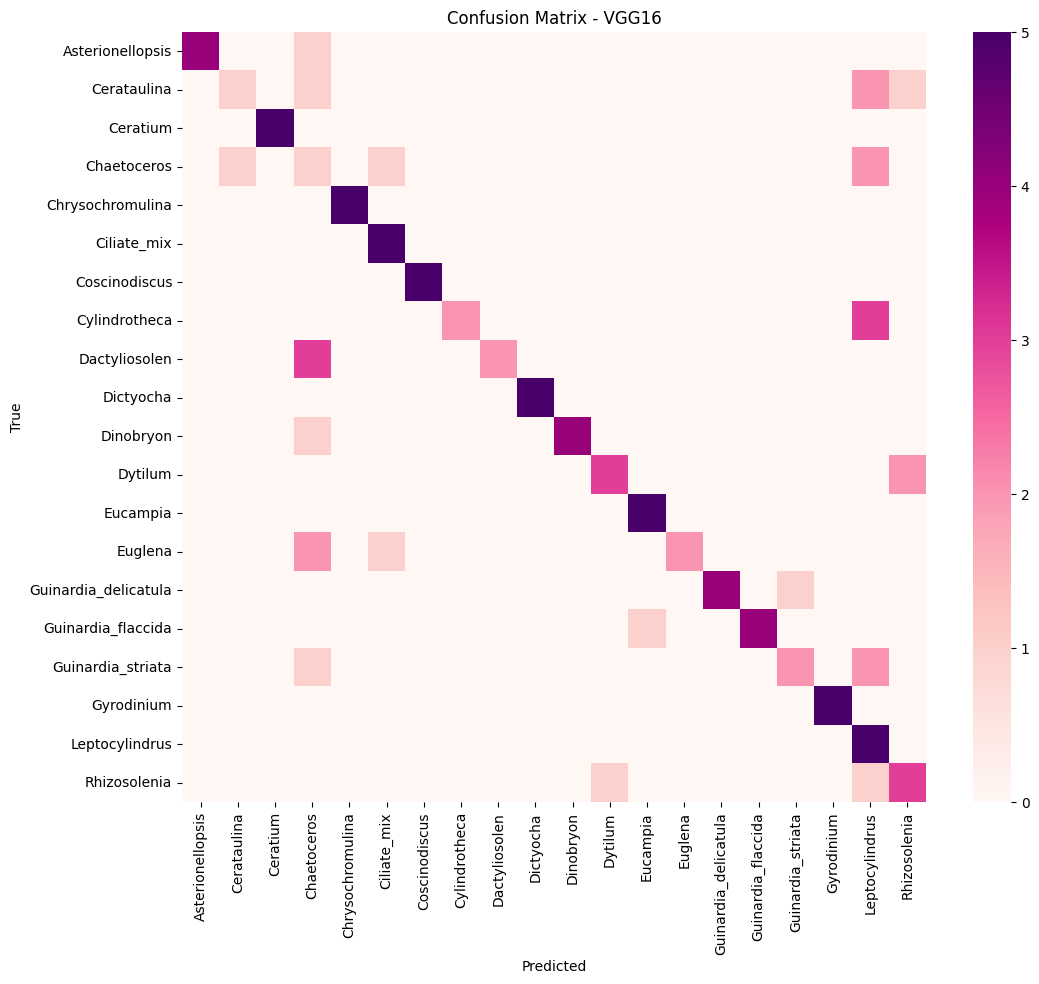

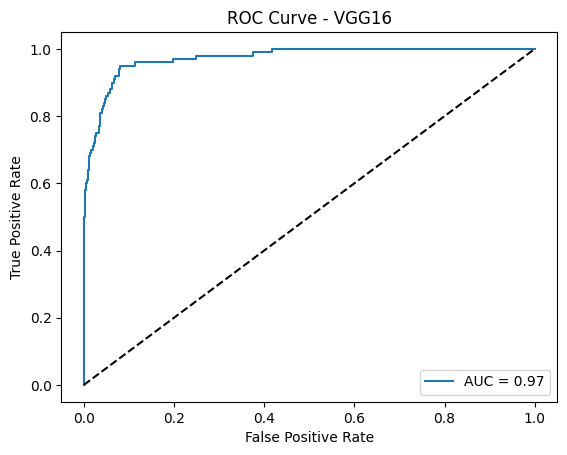


Evaluating ResNet50V2...
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step


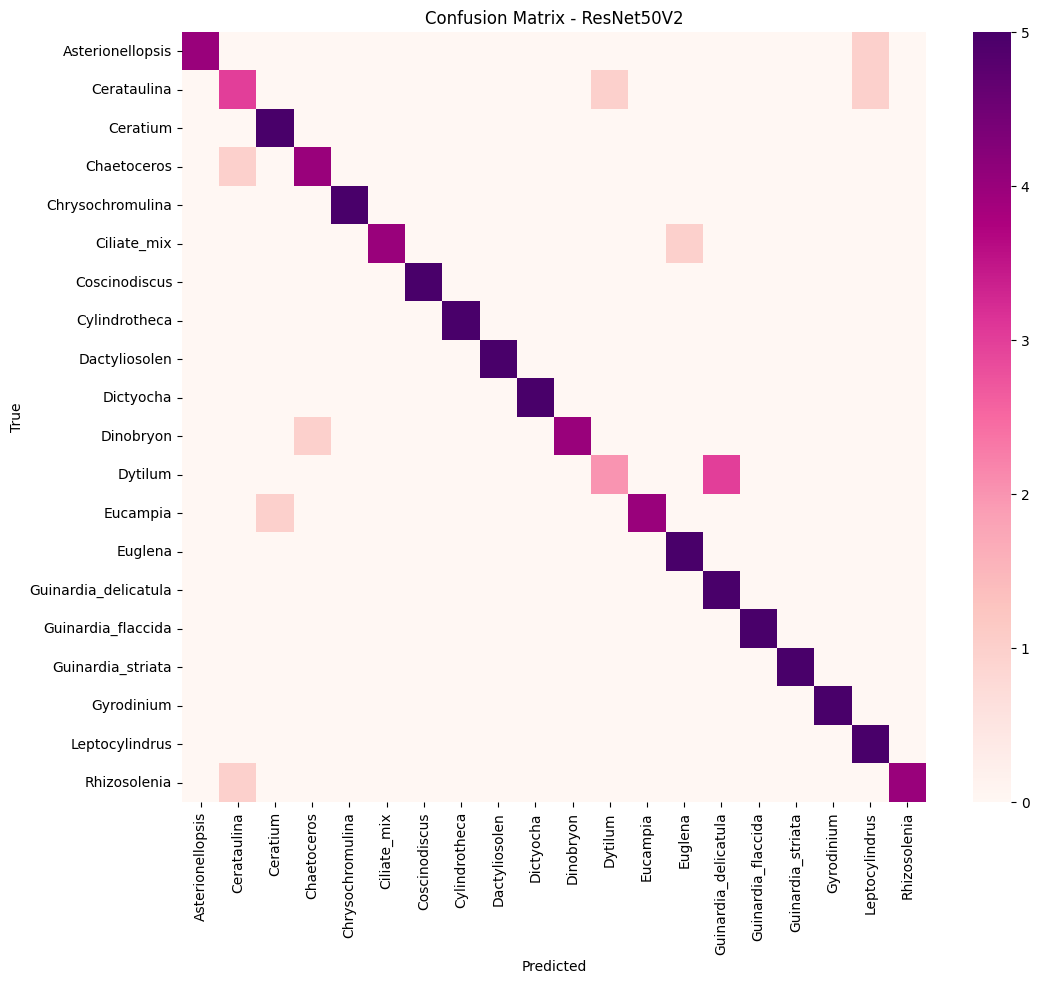

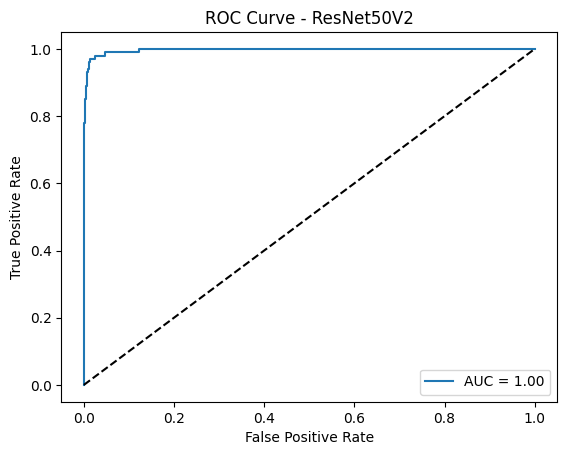


Evaluating InceptionV3...


3/4 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000112712E67A0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step


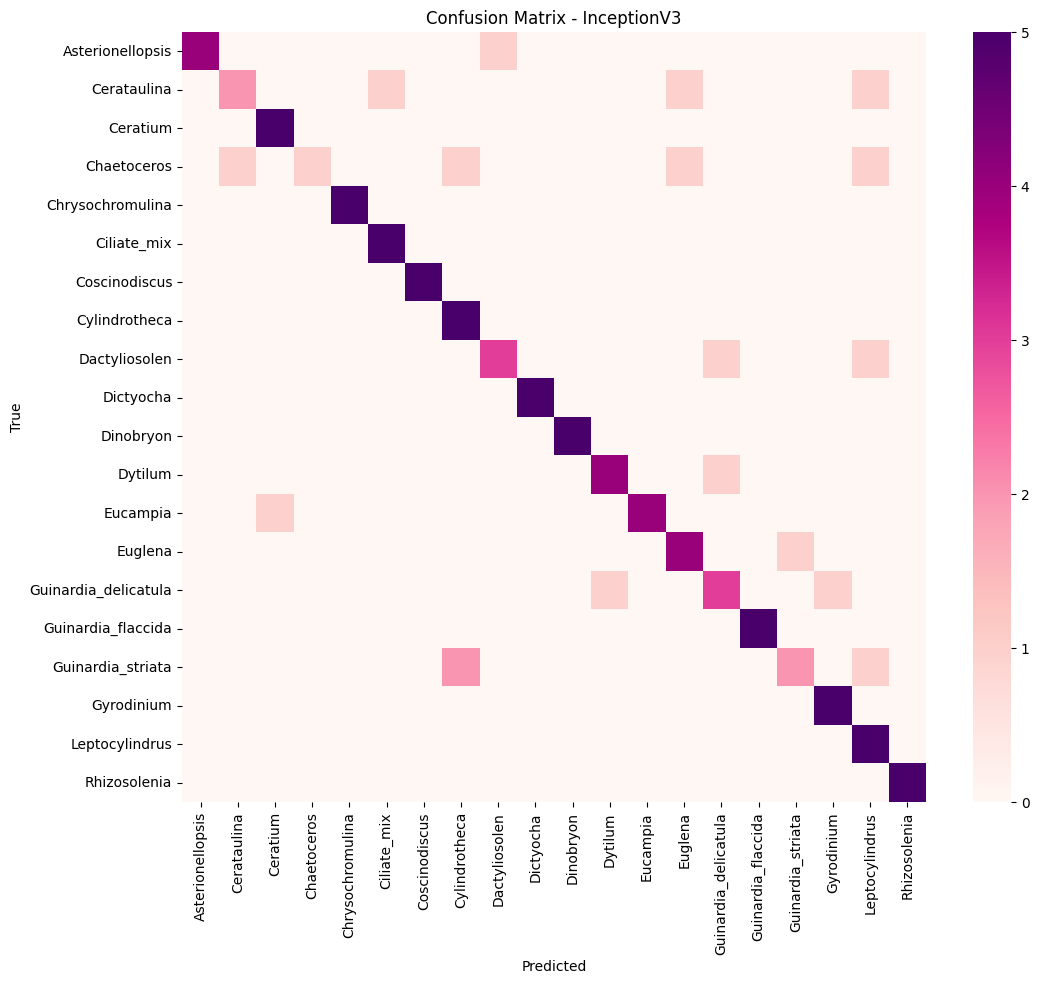

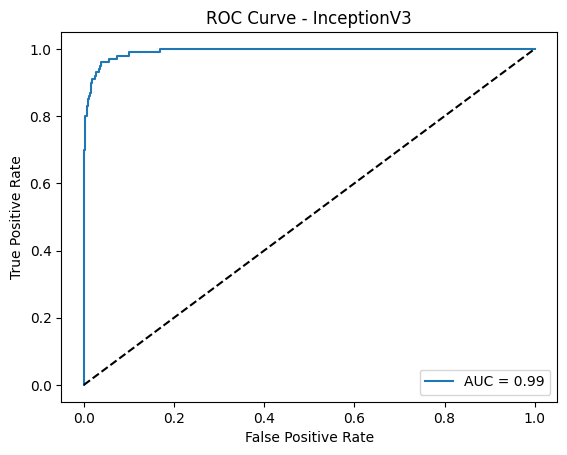


Evaluating Xception...
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step


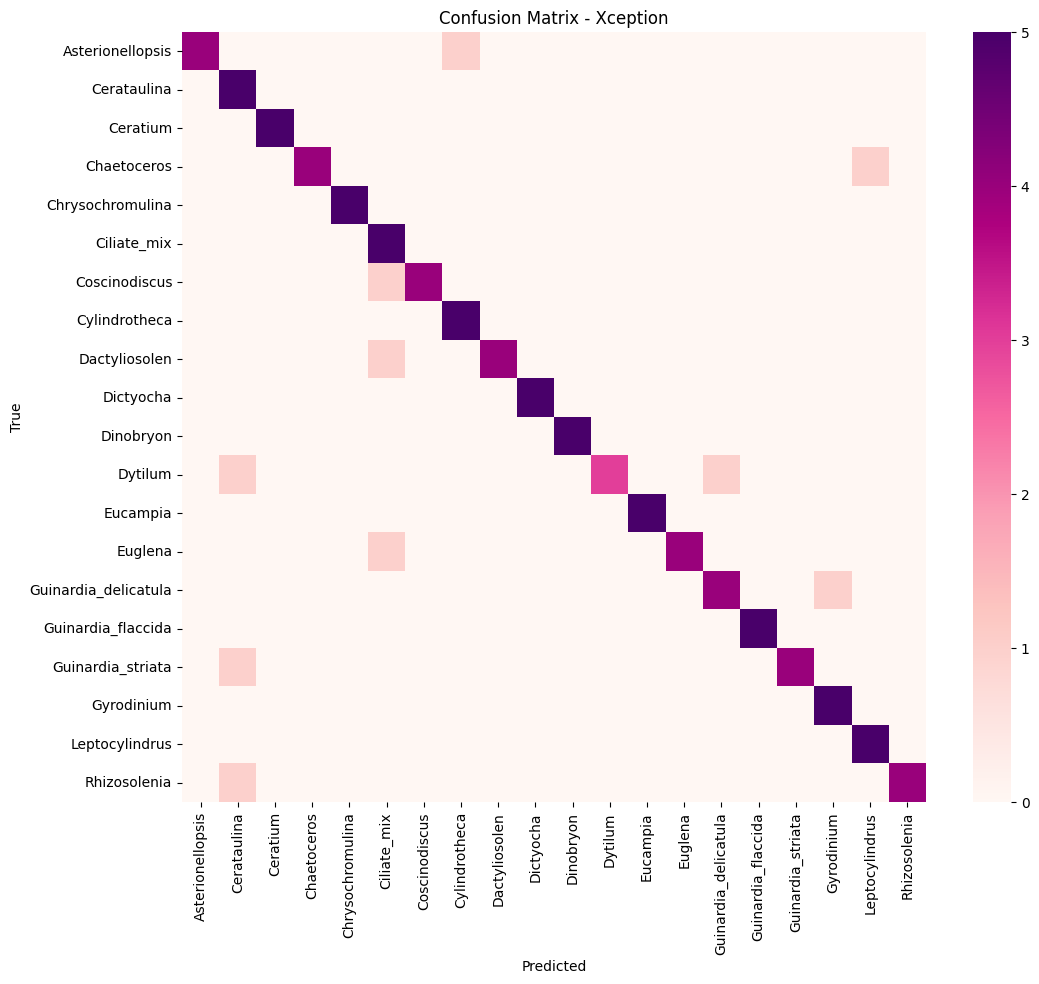

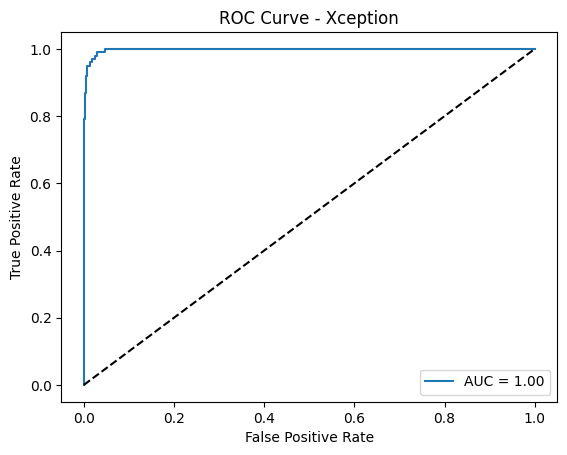


Evaluating MobileNetV2...
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 966ms/step


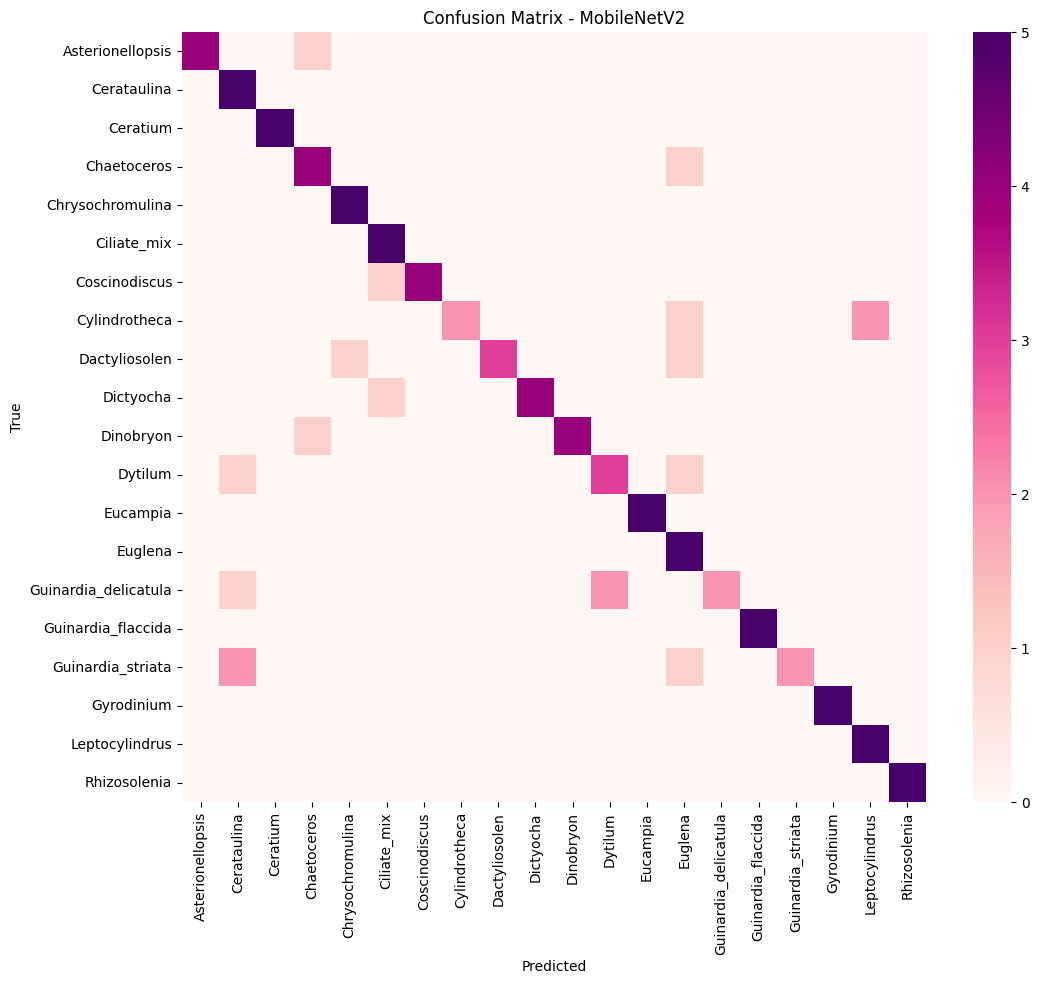

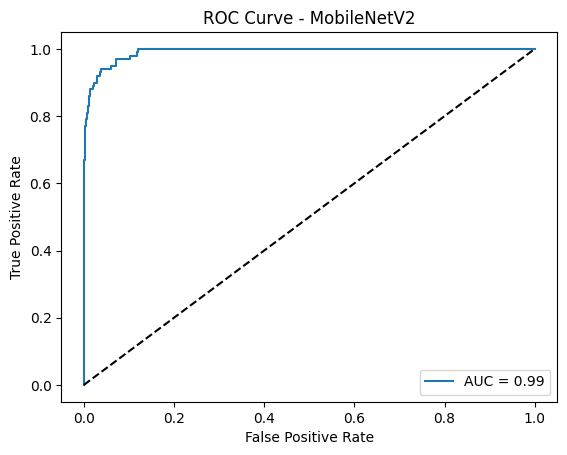

In [7]:
results_summary, all_class_reports = [], {}
Y_true = test_generator.classes

for name, model in compiled_models.items():
    print(f"\nEvaluating {name}...")
    Y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(Y_pred, axis=1)
    
    # Classification Report
    report = classification_report(Y_true, y_pred_classes, target_names=class_labels, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_report.to_csv(os.path.join(OUTPUT_PATH, name, f"{name}_classification_report.csv"))
    all_class_reports[name] = df_report
    
    # Confusion Matrix
    cm = confusion_matrix(Y_true, y_pred_classes)
    plt.figure(figsize=(12,10))
    sns.heatmap(cm, cmap="RdPu", xticklabels=class_labels, yticklabels=class_labels, cbar=True)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(os.path.join(OUTPUT_PATH, name, f"{name}_confusion_matrix.png"))
    plt.show()
    
    # ROC + AUC
    fpr, tpr, _ = roc_curve(tf.keras.utils.to_categorical(Y_true, NUM_CLASSES).ravel(), Y_pred.ravel())
    auc_score = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.savefig(os.path.join(OUTPUT_PATH, name, f"{name}_roc_curve.png"))
    plt.show()
    
    # Save summary
    results_summary.append({
        "Model": name,
        "Accuracy": report["accuracy"],
        "Macro Precision": report["macro avg"]["precision"],
        "Macro Recall": report["macro avg"]["recall"],
        "Macro F1": report["macro avg"]["f1-score"],
        "AUC": auc_score,
        "Training Time (s)": history[name][1],
        "Params (M)": np.round(model.count_params()/1e6, 2)
    })

## Save Summary Results

In [8]:
results_df = pd.DataFrame(results_summary)
results_df.to_csv(os.path.join(OUTPUT_PATH, "all_models_summary.csv"), index=False)

combined_class_reports = pd.concat({k: v for k, v in all_class_reports.items()}, axis=1)
combined_class_reports.to_csv(os.path.join(OUTPUT_PATH, "per_class_comparison.csv"))

print("All metrics, reports, and plots saved successfully.")

All metrics, reports, and plots saved successfully.


## Training History Plots

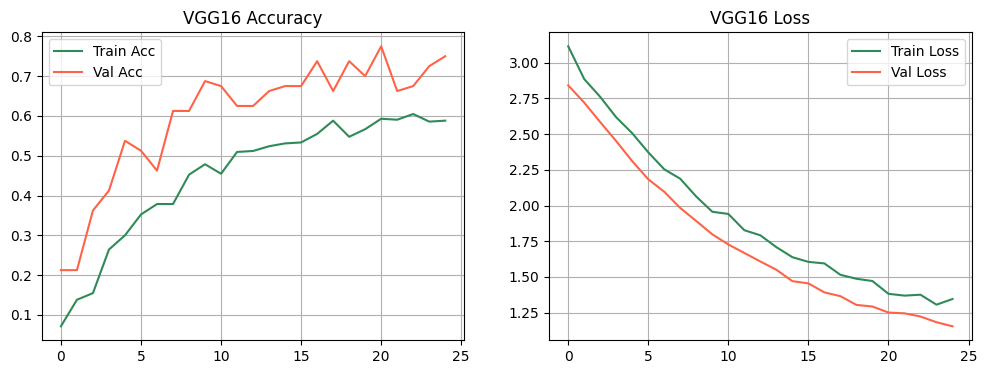

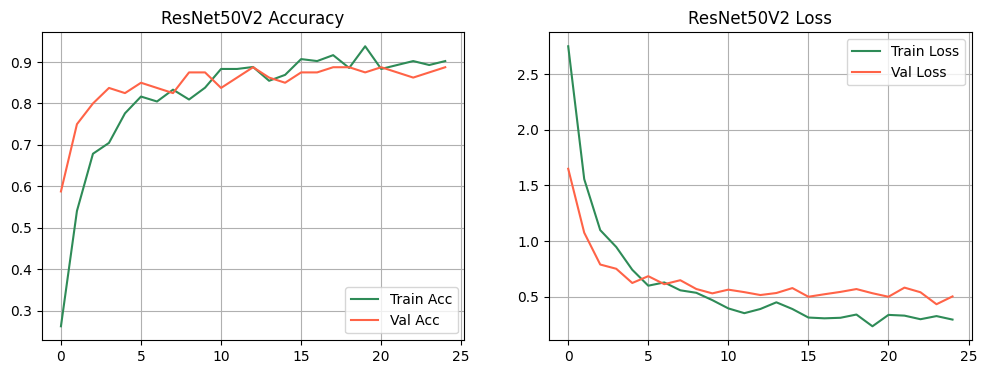

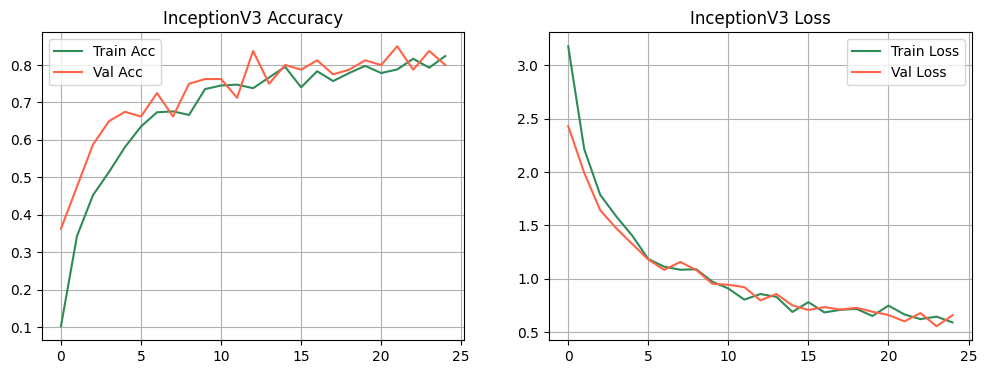

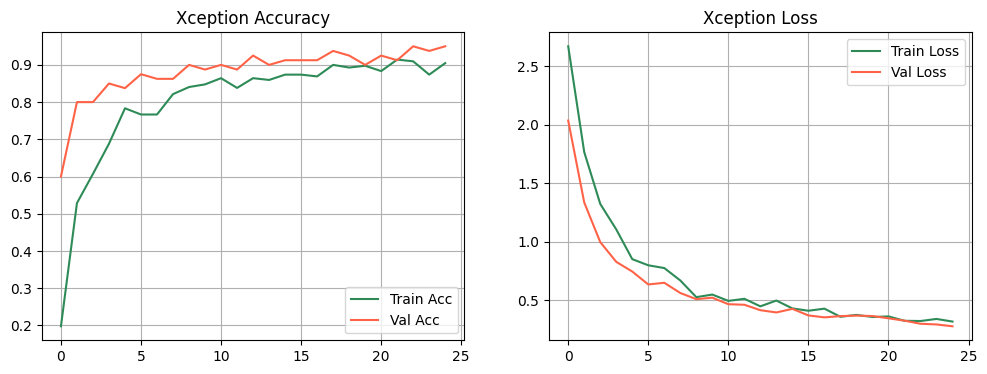

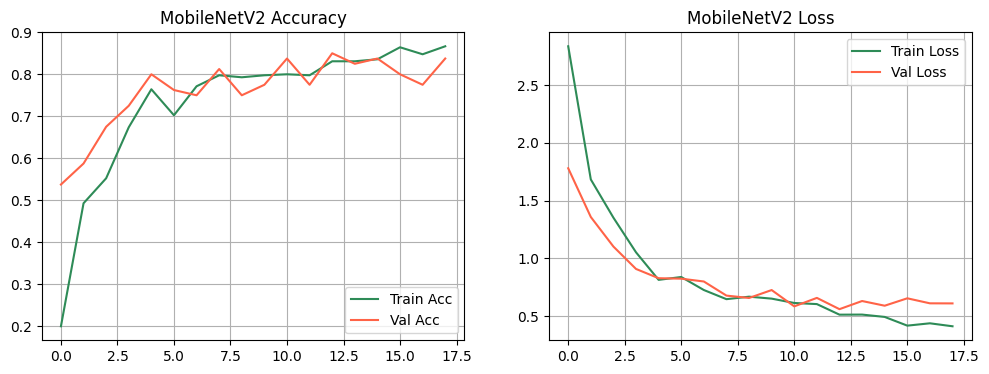

In [9]:
for name, (hist, _) in history.items():
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(hist.history['accuracy'], label='Train Acc', color = 'seagreen')
    plt.plot(hist.history['val_accuracy'], label='Val Acc', color = 'tomato')
    plt.title(f"{name} Accuracy")
    plt.legend()
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(hist.history['loss'], label='Train Loss', color = 'seagreen')
    plt.plot(hist.history['val_loss'], label='Val Loss', color = 'tomato')
    plt.title(f"{name} Loss")
    plt.legend()
    plt.grid()

    plt.savefig(os.path.join(OUTPUT_PATH, name, f"{name}_training_history.png"))
    plt.show()


=== Inference Results for VGG16 ===


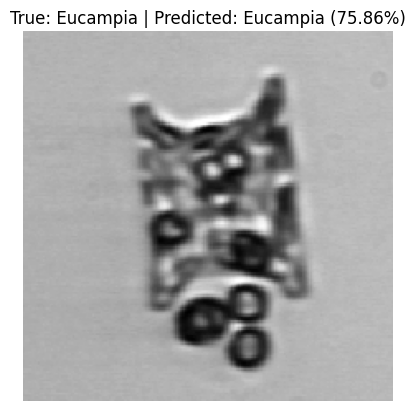

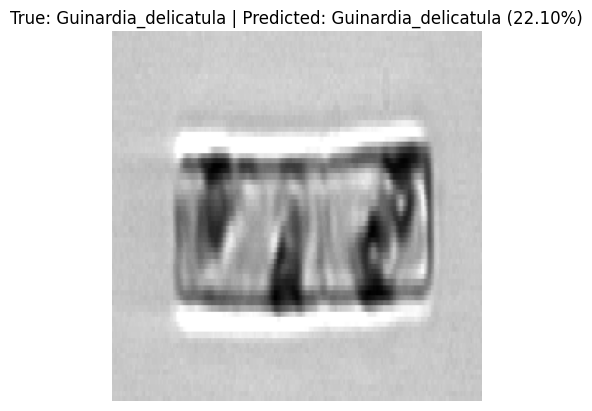

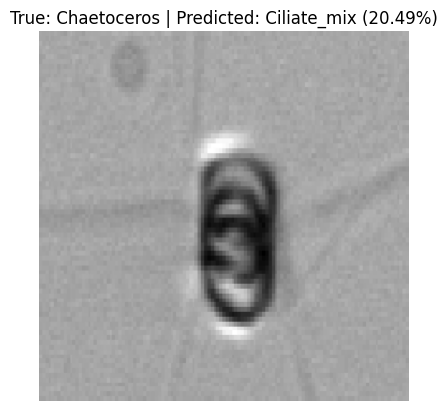

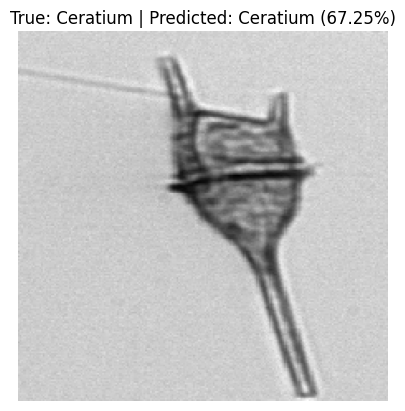

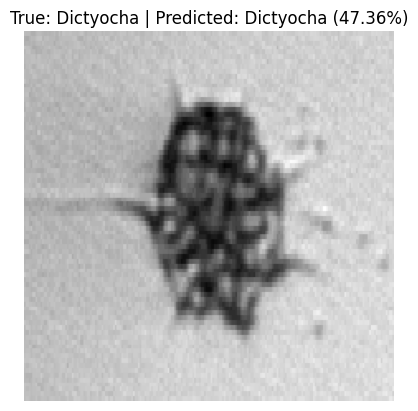


=== Inference Results for ResNet50V2 ===


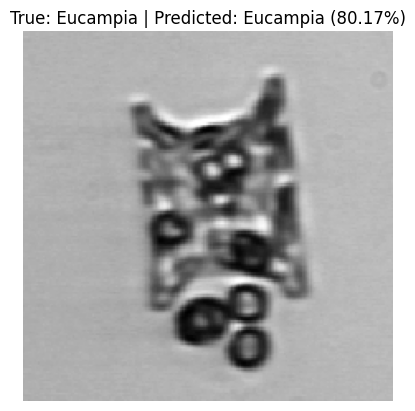

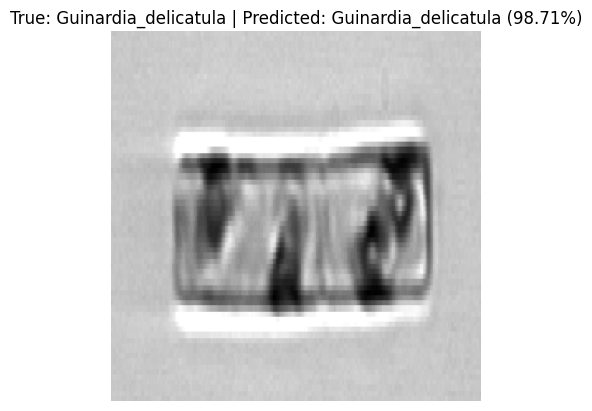

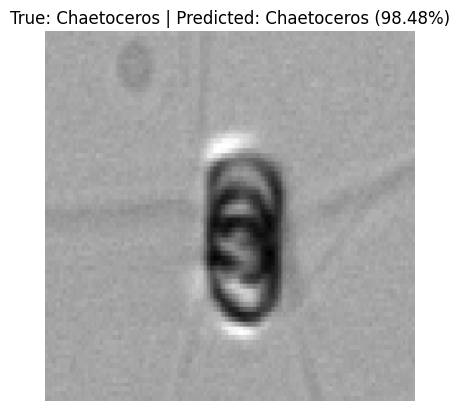

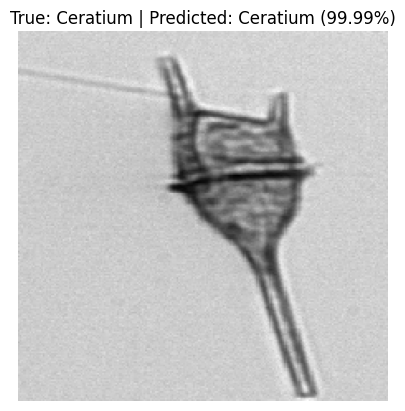

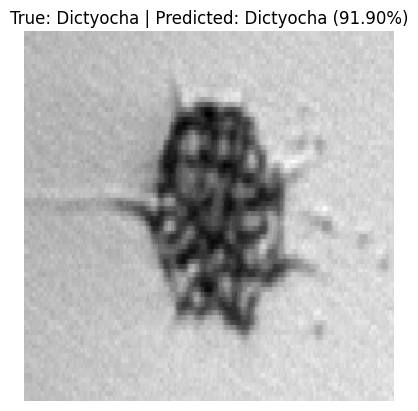


=== Inference Results for InceptionV3 ===


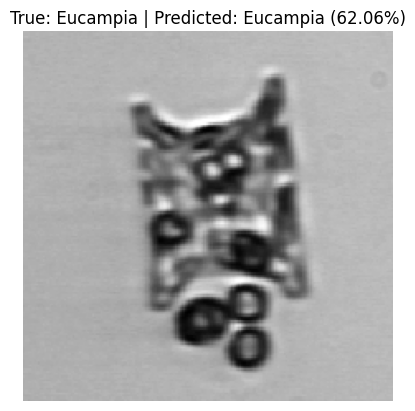

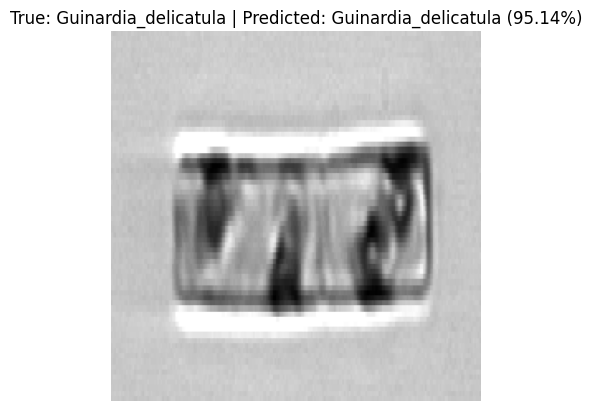

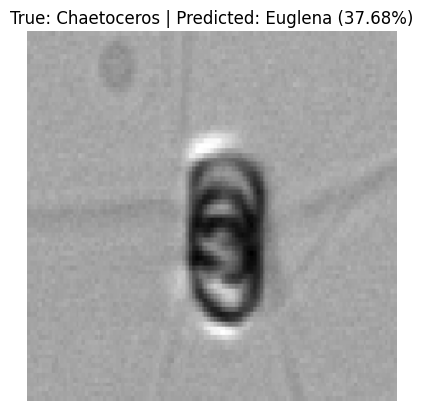

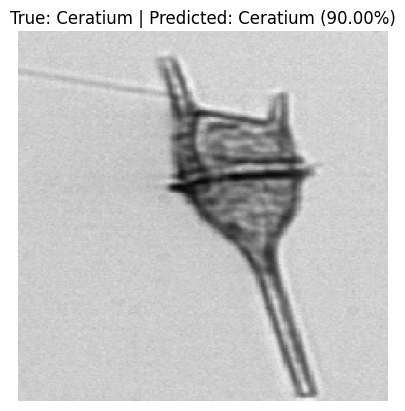

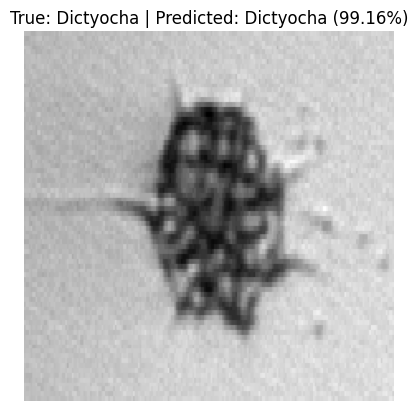


=== Inference Results for Xception ===


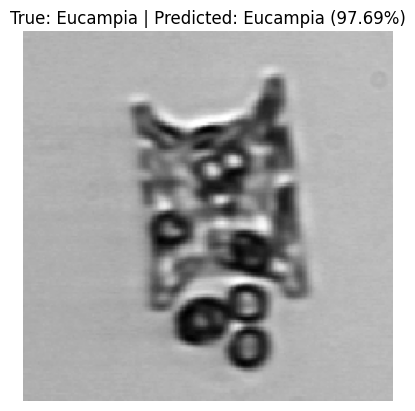

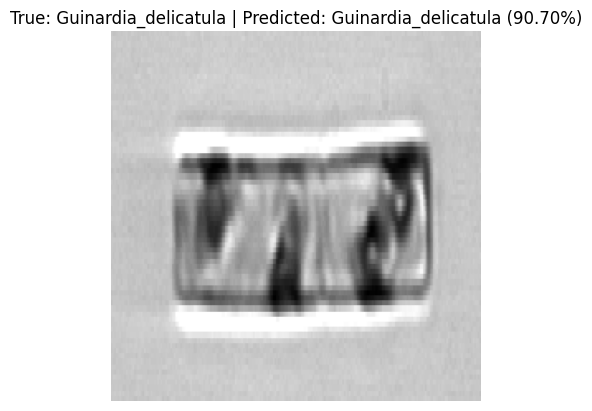

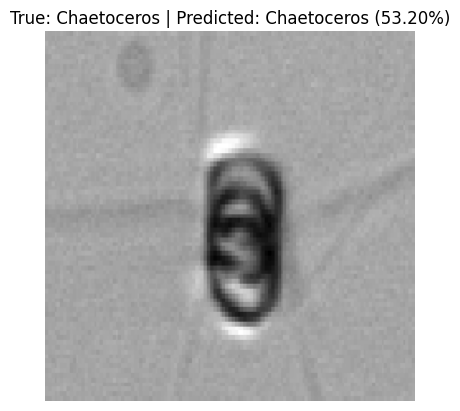

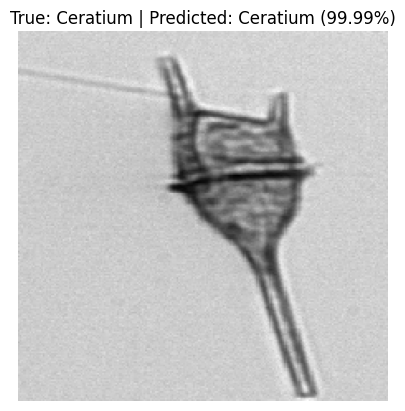

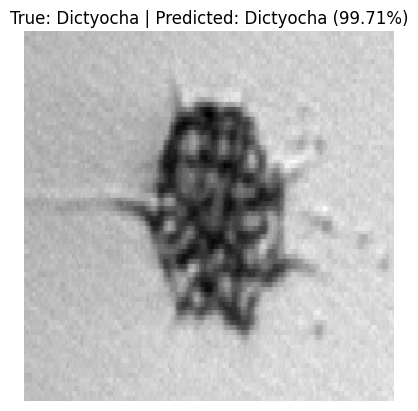


=== Inference Results for MobileNetV2 ===


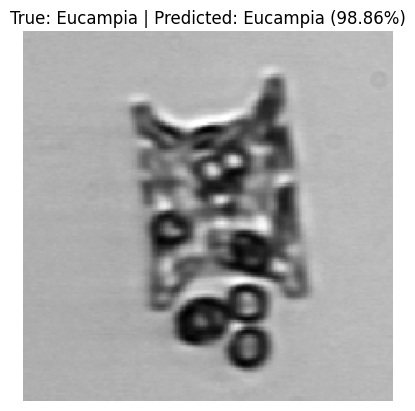

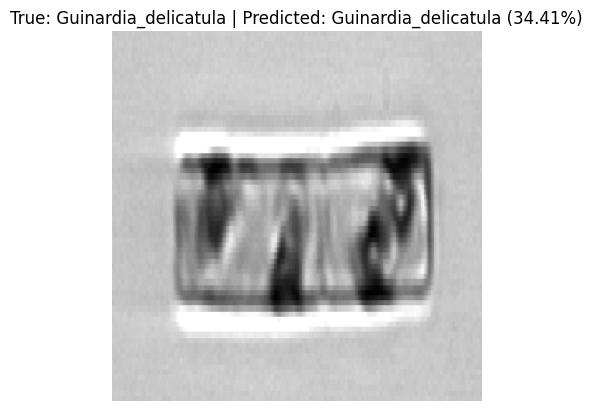

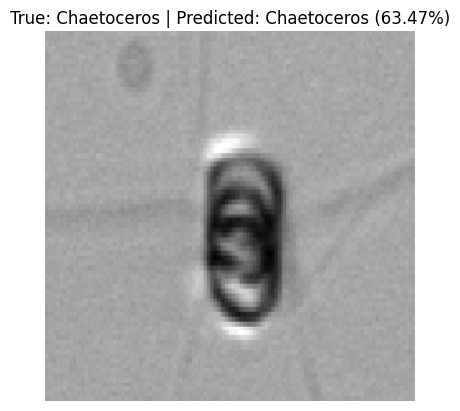

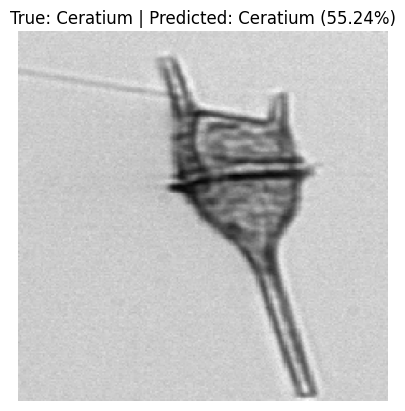

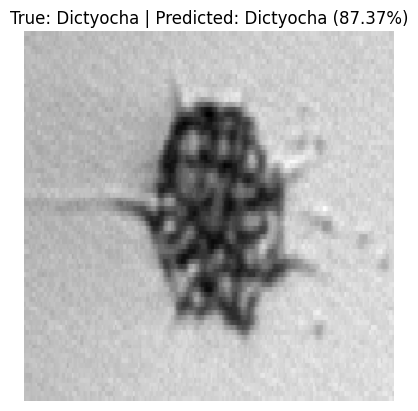

In [10]:
# Inference Testing on Random Samples for Each Model with Confidence Scores
import random

# Get all class labels
class_labels = list(test_generator.class_indices.keys())

# Reset test generator to ensure consistent sampling
test_generator.reset()

# Pick random indices from the test set
num_samples = 5  # number of samples to test per model
random_indices = random.sample(range(len(test_generator.filenames)), num_samples)

for model_name, model in compiled_models.items():
    print(f"\n=== Inference Results for {model_name} ===")
    
    for idx in random_indices:
        img_path = os.path.join(DATASET_PATH, test_generator.filenames[idx])
        
        # Load and preprocess image
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMAGE_SIZE)
        img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)  # add batch dimension
        
        # Predict
        prediction = model.predict(img_array, verbose=0)
        predicted_index = np.argmax(prediction)
        predicted_class = class_labels[predicted_index]
        confidence = prediction[0][predicted_index] * 100  # convert to percentage
        true_class = class_labels[test_generator.classes[idx]]
        
        # Display results
        plt.imshow(tf.keras.preprocessing.image.array_to_img(img_array[0]))
        plt.axis("off")
        plt.title(f"True: {true_class} | Predicted: {predicted_class} ({confidence:.2f}%)")
        plt.show()

In [11]:
# Per-Class Metrics for Each Model & Export

from sklearn.metrics import precision_recall_fscore_support

metrics_list = []

for model_name, model in compiled_models.items():
    print(f"\n=== Per-Class Metrics for {model_name} ===")
    
    # Predict on test set
    test_generator.reset()
    y_pred = model.predict(test_generator, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes
    
    # Calculate per-class precision, recall, f1
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred_classes, labels=range(NUM_CLASSES), zero_division=0
    )
    
    df = pd.DataFrame({
        'Class': class_labels,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })
    df['Model'] = model_name
    print(df.head())  # print first few rows
    
    metrics_list.append(df)

# Concatenate and export all results
metrics_all = pd.concat(metrics_list, axis=0)
metrics_all.to_csv("per_class_metrics.csv", index=False)
print("Per-class metrics exported to per_class_metrics.csv")


=== Per-Class Metrics for VGG16 ===
              Class  Precision  Recall  F1-Score  Model
0  Asterionellopsis        1.0     0.8  0.888889  VGG16
1       Cerataulina        0.5     0.2  0.285714  VGG16
2          Ceratium        1.0     1.0  1.000000  VGG16
3       Chaetoceros        0.1     0.2  0.133333  VGG16
4  Chrysochromulina        1.0     1.0  1.000000  VGG16

=== Per-Class Metrics for ResNet50V2 ===
              Class  Precision  Recall  F1-Score       Model
0  Asterionellopsis   1.000000     0.8  0.888889  ResNet50V2
1       Cerataulina   0.600000     0.6  0.600000  ResNet50V2
2          Ceratium   0.833333     1.0  0.909091  ResNet50V2
3       Chaetoceros   0.800000     0.8  0.800000  ResNet50V2
4  Chrysochromulina   1.000000     1.0  1.000000  ResNet50V2

=== Per-Class Metrics for InceptionV3 ===
              Class  Precision  Recall  F1-Score        Model
0  Asterionellopsis   1.000000     0.8  0.888889  InceptionV3
1       Cerataulina   0.666667     0.4  0.500000  In

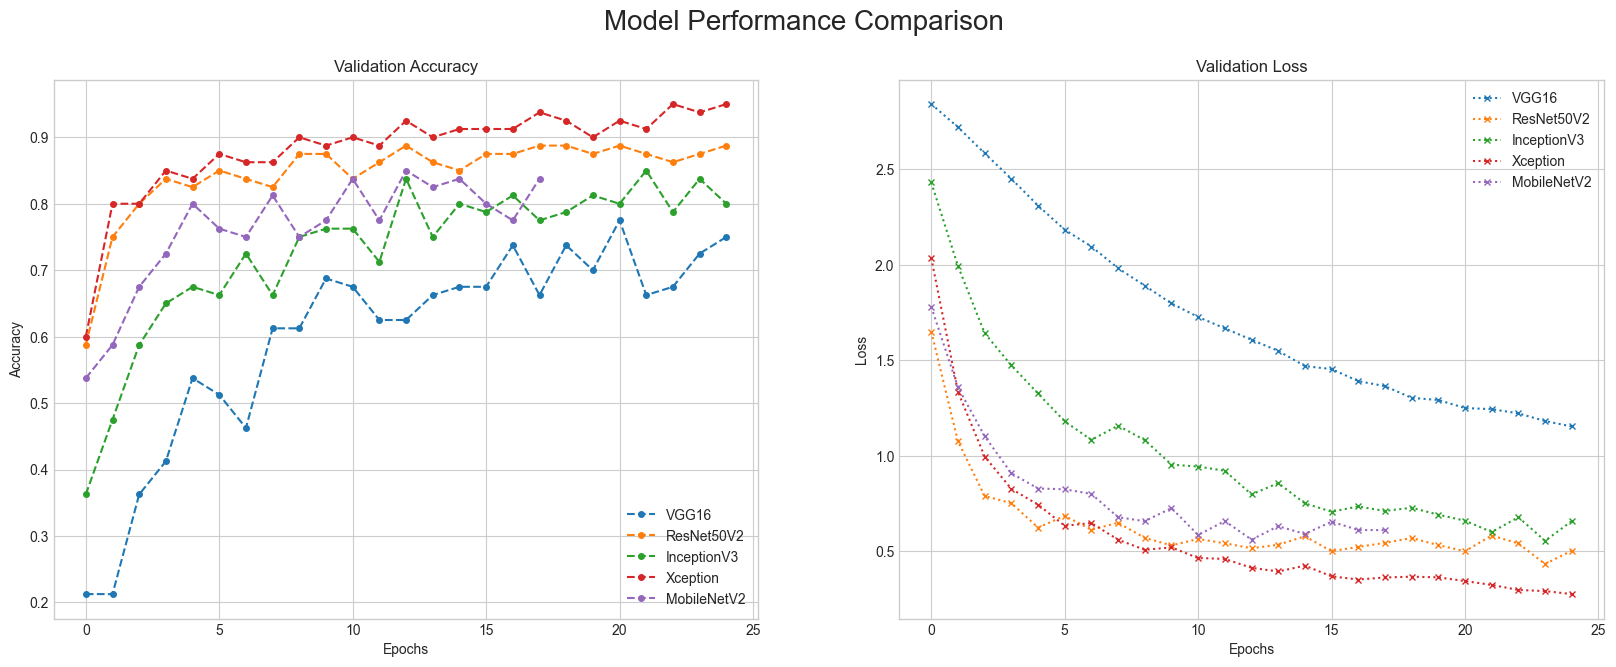

In [12]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle('Model Performance Comparison', fontsize=20)

# Plot Training & Validation Accuracy
ax1.set_title('Validation Accuracy')
for name, (hist, _) in history.items():
    ax1.plot(hist.history['val_accuracy'], label=name, marker='o', linestyle='--', markersize=4)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot Training & Validation Loss
ax2.set_title('Validation Loss')
for name, (hist, _) in history.items():
    ax2.plot(hist.history['val_loss'], label=name, marker='x', linestyle=':', markersize=5)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()